In [16]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("cfg/yolov3-tiny.cfg","weights/yolov3-tiny_3000.weights")

In [17]:
cv2.__version__ # version is important

'4.5.2'

In [18]:
layer_names = net.getLayerNames()
print(layer_names)
len(layer_names)

['conv_0', 'bn_0', 'leaky_1', 'pool_1', 'conv_2', 'bn_2', 'leaky_3', 'pool_3', 'conv_4', 'bn_4', 'leaky_5', 'pool_5', 'conv_6', 'bn_6', 'leaky_7', 'pool_7', 'conv_8', 'bn_8', 'leaky_9', 'pool_9', 'conv_10', 'bn_10', 'leaky_11', 'pool_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'conv_15', 'permute_16', 'yolo_16', 'identity_17', 'conv_18', 'bn_18', 'leaky_19', 'upsample_19', 'concat_20', 'conv_21', 'bn_21', 'leaky_22', 'conv_22', 'permute_23', 'yolo_23']


48

In [19]:
# print (net.getUnconnectedOutLayers())
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers

['yolo_16', 'yolo_23']

In [31]:
classes = [line.strip() for line in open("cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]

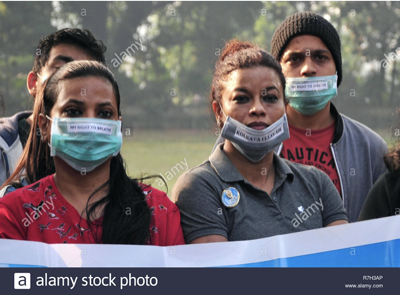

In [32]:
from PIL import Image
test_path = '/Users/jackyyeh/gatos/delete/images/maksssksksss29.png'
Image.open(test_path)

In [33]:
img = cv2.imread(test_path)
img.shape

(295, 400, 3)

## 利用YOLOv3 模型辨識圖片

- 320 x 320 (high speed, less accuracy)
- 416 x 416 (moderate speed, moderate accuracy)
- 608 x 608 (less speed, high accuracy)

In [34]:
img = cv2.resize(img, None, fx=0.4, fy=0.4)
height, width, channels = img.shape 
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

In [35]:
len(outs)

2

In [36]:
outs[0].shape

(507, 8)

In [37]:
class_ids = []
confidences = []
boxes = []
confidence_thres = 0.3

for out in outs:
    for detection in out:
        tx, ty, tw, th, confidence = detection[0:5]
        scores = detection[5:]
        class_id = np.argmax(scores)  
        if confidence > confidence_thres:   
            center_x = int(tx * width)
            center_y = int(ty * height)
            w = int(tw * width)
            h = int(th * height)
            
            # 取得箱子方框座標
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [38]:
len(boxes)

4

## Non-maxima Suppression

In [39]:
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)

## 框住偵測物件區域

In [40]:
font = cv2.FONT_HERSHEY_PLAIN

for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[class_ids[i]]
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
        cv2.putText(img, label, (x, y - 5), font, 1, color, 1)
img.shape

(118, 160, 3)

Populating the interactive namespace from numpy and matplotlib


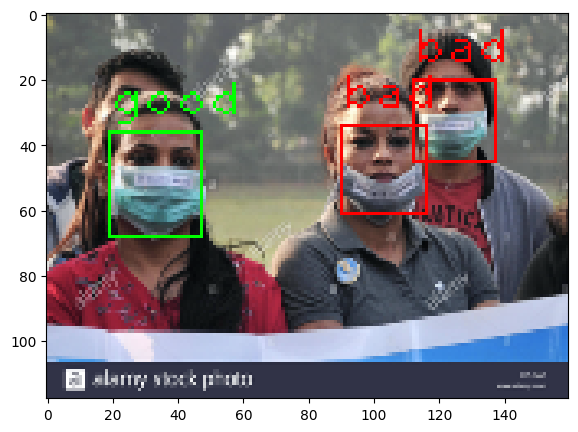

In [41]:
%pylab inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 5]
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

## Encapsulate Detection Process as a Function

In [42]:
import cv2
import numpy as np
net = cv2.dnn.readNetFromDarknet("cfg/yolov3-tiny.cfg","weights/yolov3-tiny_3000.weights")
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
classes = [line.strip() for line in open("cfg_mask/obj.names")]
colors = [(0,0,255),(255,0,0),(0,255,0)]
confidence_thres = 0.3

def yolo_detect(frame):
    # forward propogation
    img = cv2.resize(frame, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape 
    blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # get detection boxes
    class_ids = []
    confidences = []
    boxes = []
    
    for out in outs:
        for detection in out:
            tx, ty, tw, th, confidence = detection[0:5]
            scores = detection[5:]
            class_id = np.argmax(scores)  
            if confidence > confidence_thres:   
                center_x = int(tx * width)
                center_y = int(ty * height)
                w = int(tw * width)
                h = int(th * height)

                # 取得箱子方框座標
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
    # draw boxes
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.3, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
            cv2.putText(img, label, (x, y -5), font, 1, color, 1)
    return img

## Real-time Detection Using a Camera

In [43]:
import cv2
import imutils
import time

VIDEO_IN = cv2.VideoCapture(0)

while True:
    hasFrame, frame = VIDEO_IN.read()
    
    img = yolo_detect(frame)
    cv2.imshow("Frame", imutils.resize(img, width=850))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()